In [1]:
%pylab inline
import random

import numpy as np
import random
import pickle
from tqdm import tqdm
import letor_metrics

Populating the interactive namespace from numpy and matplotlib


In [2]:
raw_data = np.loadtxt('./data/ml-1m/ratings.dat', delimiter='::')

In [3]:
from dataset import TripletsDataset

In [4]:
ds = TripletsDataset(raw_data, threshold_user=60, rnd_seed=42)
ds.train_test_split(n_train=50)

Split users:  12%|█▏        | 488/3938 [00:00<00:01, 2506.24it/s]

In [5]:
pickle.dump(ds, open('./tmp/ds.pkl', 'wb'))
# ds = pickle.load(open('./tmp/ds.pkl', 'rb'))

In [6]:
ds.init_cached_random()

# define model

In [14]:
import tensorflow as tf
import bprnn

In [15]:
import imp

In [16]:
imp.reload(bprnn)

<module 'bprnn' from '/Users/mikhail/std/repos/nnmf/bprnn.py'>

In [17]:
model.destroy()

NameError: name 'model' is not defined

In [18]:
N_USERS = 6041 #int(max(raw_data[:, 0])) + 1
N_ITEMS = 3953 #int(max(raw_data[:, 1])) + 1
N_EMBEDDINGS = 5

In [19]:
import tensorflow.contrib.slim as slim

def inner_network(user_emb, item_emb):
    joined_input = tf.concat(1, [user_emb, item_emb])
    net = slim.fully_connected(inputs=joined_input, num_outputs=128, activation_fn=tf.nn.relu)
#     net = slim.dro
    net = slim.fully_connected(inputs=net, num_outputs=1, activation_fn=None)
    return net

In [20]:
model = bprnn.BPR_NN(N_USERS, N_ITEMS, N_EMBEDDINGS, alpha=0.1, beta=0.9, alpha_reg=0.0, inner_net=inner_network)
model.build_graph()
model.initialize_session()

In [21]:
losses = []
batch_size = 1024
for n_batches, cur_optim in [(5000, model.trainer_2)]:
    for i in tqdm(range(n_batches)):
        batch = ds.sample_train_batch(n_samples=batch_size)
        fd = {
            model.user_ids:  batch['users'], 
            model.left_ids:  batch['left_items'],
            model.right_ids: batch['right_items'],
            model.target_y:  batch['y'],
        }
        el, nl, reg, t, _ = model.session.run(
            [model.embedding_loss, model.net_loss, model.regularization, model.target, cur_optim], 
            feed_dict=fd
        )
        losses.append((el, nl, reg, t))
        if i%500==0:
            user_norm = np.linalg.norm(model.weights_u)
            item_norm = np.linalg.norm(model.weights_i)
            print('[it {}] weight norms, users: {}, items: {}'.format(i, user_norm, item_norm))
            print('[it {}] metrics (emb_loss, net_loss, reg, target): {}'.format(i, losses[-1]))

  0%|          | 11/5000 [00:00<02:28, 33.67it/s]

[it 0] weight norms, users: 81.46590423583984, items: 100.2402114868164
[it 0] metrics (emb_loss, net_loss, reg, target): (0.72836941, 0.6938653, 4.9899721, 0.69731569)


 10%|█         | 511/5000 [00:06<00:52, 85.64it/s]

[it 500] weight norms, users: 90.01997375488281, items: 114.67362976074219
[it 500] metrics (emb_loss, net_loss, reg, target): (0.48317152, 0.41452926, 7.0167999, 0.42139348)


 20%|██        | 1014/5000 [00:11<00:43, 91.69it/s]

[it 1000] weight norms, users: 96.71449279785156, items: 125.23719787597656
[it 1000] metrics (emb_loss, net_loss, reg, target): (0.44768009, 0.3997947, 8.6399269, 0.40458322)


 30%|███       | 1511/5000 [00:17<00:38, 90.48it/s]

[it 1500] weight norms, users: 102.38916778564453, items: 133.40005493164062
[it 1500] metrics (emb_loss, net_loss, reg, target): (0.41873068, 0.35703397, 9.8940372, 0.36320364)


 40%|████      | 2016/5000 [00:23<00:33, 89.26it/s]

[it 2000] weight norms, users: 107.57781982421875, items: 140.02235412597656
[it 2000] metrics (emb_loss, net_loss, reg, target): (0.4136183, 0.33843493, 11.145845, 0.34595329)


 50%|█████     | 2513/5000 [00:28<00:27, 89.37it/s]

[it 2500] weight norms, users: 112.19693756103516, items: 145.63406372070312
[it 2500] metrics (emb_loss, net_loss, reg, target): (0.42060125, 0.34933865, 11.799074, 0.35646492)


 60%|██████    | 3010/5000 [00:34<00:22, 89.29it/s]

[it 3000] weight norms, users: 116.24853515625, items: 150.6470947265625
[it 3000] metrics (emb_loss, net_loss, reg, target): (0.43124175, 0.35314375, 12.984565, 0.36095354)


 70%|███████   | 3516/5000 [00:40<00:16, 90.37it/s]

[it 3500] weight norms, users: 120.19923400878906, items: 155.0016632080078
[it 3500] metrics (emb_loss, net_loss, reg, target): (0.40425462, 0.3200475, 13.259968, 0.3284682)


 80%|████████  | 4010/5000 [00:46<00:11, 88.17it/s]

[it 4000] weight norms, users: 123.65540313720703, items: 158.8890380859375
[it 4000] metrics (emb_loss, net_loss, reg, target): (0.41338634, 0.30756542, 14.175459, 0.31814748)


 90%|█████████ | 4515/5000 [00:51<00:05, 89.24it/s]

[it 4500] weight norms, users: 126.58199310302734, items: 162.5249481201172
[it 4500] metrics (emb_loss, net_loss, reg, target): (0.41034538, 0.29752135, 15.005938, 0.30880377)


100%|██████████| 5000/5000 [00:57<00:00, 87.04it/s]


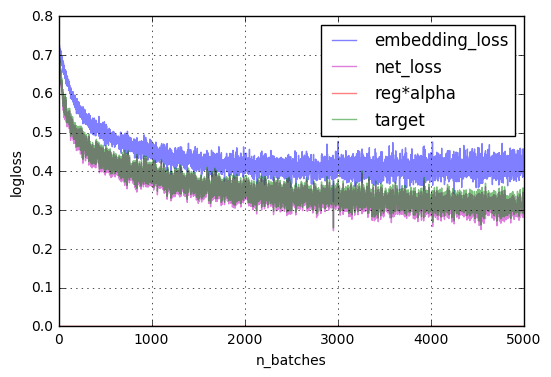

In [22]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1] for x in losses], c='m', label='net_loss', alpha=0.5)
plot([x[2]*model.alpha_reg for x in losses], c='r', label='reg*alpha', alpha=0.5)
plot([x[3] for x in losses], c='g', label='target', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [23]:
ndcg_vals = []
for u in tqdm(ds.data_keys, desc='Prediction', leave=True):
    response = np.zeros(len(ds.test[u]))
    fd = {
            model.user_ids:  (np.ones(len(ds.test[u]))*u).astype(np.int32), 
            model.left_ids:  np.array([i for (i, r) in ds.test[u]]).astype(np.int32),
        }
    response += model.session.run(model.embedding_left, feed_dict=fd)[:, 0]
    response += model.session.run(model.left_output, feed_dict=fd)[:, 0]

    # make relevances
    relevances = np.array([r for (i, r) in ds.test[u]])
    predicted_ranking = np.argsort(-response)
    # calc score
    gain = letor_metrics.ndcg_from_ranking(relevances, predicted_ranking, 10)
    ndcg_vals.append(gain)

Prediction: 100%|██████████| 3938/3938 [00:03<00:00, 1005.84it/s]


In [24]:
np.mean(ndcg_vals)

0.72509002342667983